In [1]:
import pytorch_lightning as pl
from models import UNETModule
import torch
from torch.utils.data import DataLoader
from datasets.water_bodies_dataset import WaterBodiesDataset, SimpleWaterBodiesDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

/home/rafael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

unet_module = UNETModule.load_from_checkpoint("../model.ckpt")

from datasets.water_bodies_dataset import PredictionWaterBodiesDataset

root = "../water-segmentation-vtx/dataset/"
test_images = os.path.join("../water-segmentation-vtx/dataset/", "testset/images")
filenames = [os.path.join(test_images, image) for image in os.listdir(test_images)]
reference_images = []
for filename in filenames:
    if "aix" not in filename and "balma" not in filename and "Cabrespine" not in filename and "mas-de-py" not in filename:
        reference_images.append(filename)

print(reference_images)
prediction_transform = A.Compose([
    #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True, p=1),
    #A.HistogramMatching(reference_images=reference_images, always_apply=True, blend_ratio=(0.3, 0.6)),
    ToTensorV2()
])

predict_dataset = PredictionWaterBodiesDataset(root, transform=prediction_transform)
test_dataloader = DataLoader(predict_dataset, batch_size=2, shuffle=False, num_workers=1)

/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.1.2


['../water-segmentation-vtx/dataset/testset/images/salies-de-bearn_1-2023-01-07T12_31_12.jpg', '../water-segmentation-vtx/dataset/testset/images/la-salvetat-saint-gilles_1-2021-12-05T11_31_14.jpg', '../water-segmentation-vtx/dataset/testset/images/frejus_2-2021-11-25T11_07_47.jpg', '../water-segmentation-vtx/dataset/testset/images/claira_1-2023-02-16T13_32_09.jpg', '../water-segmentation-vtx/dataset/testset/images/agly-rd11_1-2023-10-03T11_05_10.jpg', '../water-segmentation-vtx/dataset/testset/images/fontenilles_1-2022-06-24T16_41_15.jpg', '../water-segmentation-vtx/dataset/testset/images/l-hopital-d-orion_1-2022-11-13T09_12_09.jpg', '../water-segmentation-vtx/dataset/testset/images/casale-monferrato_1-2023-10-16T09_31_10.jpg', '../water-segmentation-vtx/dataset/testset/images/bonrepos-sur-aussonnelle_1-2022-01-12T15_31_16.jpg', '../water-segmentation-vtx/dataset/testset/images/castets-et-castillon_1-2023-01-20T11_01_10.jpg', '../water-segmentation-vtx/dataset/testset/images/pontelagos

In [3]:
"aix" in "../water-segmentation-vtx/dataset/testset/images/aix-en-provence_1-2024-01-02T14 47 41.jpg"

True

In [4]:
unet_trainer = pl.Trainer(
    max_epochs=1,
    accelerator=accelerator,
    devices=1,
)

results = unet_trainer.predict(unet_module, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-02-28 12:39:26.508935: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 12:39:26.549540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 12:39:27.275612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-

Predicting DataLoader 0: 100%|██████████| 78/78 [00:26<00:00,  2.99it/s]


In [5]:
import cv2
import numpy as np

predictions_test = {}
for batch in results:
    logits, preds, filenames = batch
    batch_size = len(filenames)
    for i in range(batch_size):
        filename = filenames[i]
        pred = preds[i, :, :, :]
        predictions_test[filename] = pred
        
        pred = (pred.squeeze(0).numpy()*255).astype(np.uint8)
        cv2.imwrite(f'../water-segmentation-vtx/results/{filename}.png', pred)
    
predictions_test

{'salies-de-bearn_1-2023-01-07T12_31_12': tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]),
 'la-salvetat-saint-gilles_1-2021-12-05T11_31_14': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]),
 'aix-en-provence_1-2024-01-02T14 47 41': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'frejus_2-2021-11-25T11_07_47': tensor([[[1., 1., 1.,  ..

In [6]:
from create_submission_csv import rle_encode, create_csv
from datetime import datetime

current_time = datetime.now()
formatted_time = current_time.strftime('%Y-%m-%d_%H-%M-%S')
filename = f'./submission_{formatted_time}.csv'

create_csv('../water-segmentation-vtx/results/', filename)

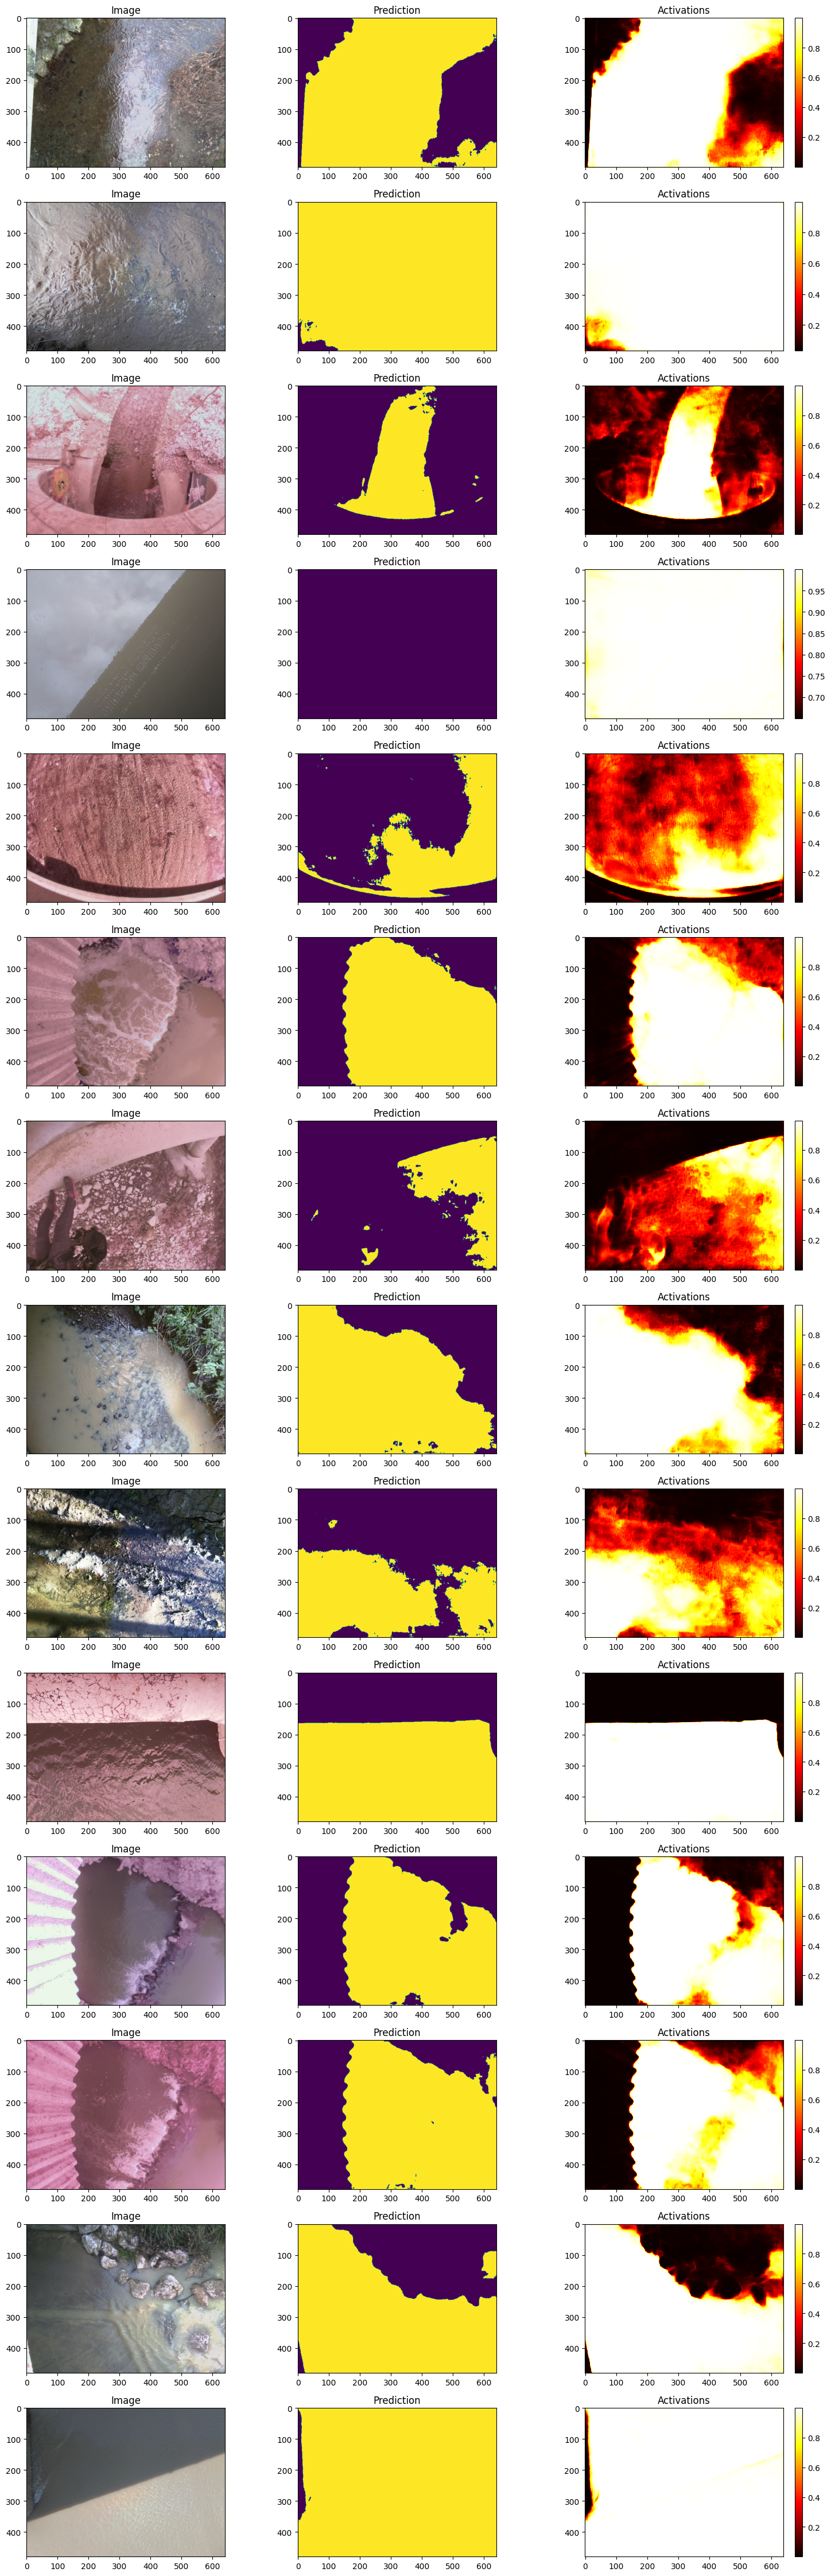

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

up_until_batch = 7
batch_results = results[:up_until_batch]

results = {}
for i, batch in enumerate(batch_results):
    logits, preds, filenames = batch
    results[2*i] = {
            "logits": logits[0],
            "preds": preds[0],
            "filename": filenames[0]
        }
    results[2*i+1] = {
            "logits": logits[1],
            "preds": preds[1],
            "filename": filenames[1]
        }

num_images = len(results)
fig, axes = plt.subplots(num_images, 3, figsize=(15, 45))
for i in range(num_images):
    logits = results[i]["logits"]
    preds = results[i]["preds"]
    filename = results[i]["filename"]
    activations = torch.sigmoid(logits).float()
    filename, image_array = predict_dataset.__getitem__(i)
    #image = np.transpose(image_array.astype(np.uint8), (1, 2, 0))
    image = image_array.permute(1, 2, 0).int()
    prediction = Image.fromarray((np.squeeze(preds.cpu().numpy(), axis=0)*255).astype(np.uint8))
    activations = np.squeeze(activations.cpu().numpy(), axis=0)
    axes[i][0].imshow(image)
    axes[i][0].set_title(f"Image")
    axes[i][1].imshow(prediction)
    axes[i][1].set_title(f"Prediction")
    activations_image = axes[i][2].imshow(activations, cmap='hot', interpolation='nearest')
    fig.colorbar(activations_image, ax=axes[i][2], fraction=0.046, pad=0.04)
    axes[i][2].set_title(f"Activations")

plt.tight_layout()

    
    

In [8]:
import cv2

predictions_test = {}
for batch in results:
    logits, preds, filenames = batch
    batch_size = len(filenames)
    for i in range(batch_size):
        filename = filenames[i]
        pred = preds[i, :, :, :]
        predictions_test[filename] = pred
        
        pred = (pred.squeeze(0).numpy()*255).astype(np.uint8)
        cv2.imwrite(f'../water-segmentation-vtx/results/{filename}.png', pred)
    
predictions_test

TypeError: cannot unpack non-iterable int object